# Trend Comparison

This notebook analyzes similarity in trends between pairs of topics.

In [1]:
import sys
import os
import pyspark
import math
from operator import add

## Load Dataset

In [2]:
import preproc as pre

dataRDD = sc.parallelize(pre.get_list())

for line in dataRDD.take(10):
    print 'Topic: {}. Tag: {},{}. Year: {}. Page count: {}. Volume count: {}'.format(
        line[0], line[1][0], line[1][1], line[2], line[3], line[4])

Topic: amber alert. Tag: n,n. Year: 1987. Page count: 1. Volume count: 1
Topic: amber alert. Tag: n,n. Year: 1990. Page count: 1. Volume count: 1
Topic: amber alert. Tag: n,n. Year: 1999. Page count: 1. Volume count: 1
Topic: amber alert. Tag: n,n. Year: 2001. Page count: 1. Volume count: 1
Topic: amber alert. Tag: n,n. Year: 2003. Page count: 2. Volume count: 2
Topic: amber alert. Tag: n,n. Year: 2005. Page count: 16. Volume count: 12
Topic: amber alert. Tag: n,n. Year: 2006. Page count: 14. Volume count: 13
Topic: amber alert. Tag: n,n. Year: 2007. Page count: 12. Volume count: 10
Topic: amber alert. Tag: n,n. Year: 2008. Page count: 11. Volume count: 11
Topic: amber alert. Tag: n,n. Year: 1987. Page count: 1. Volume count: 1


## Volume Frequency over Years

In [3]:
def volume_freq(dataRDD):
    topic_yr_to_nvol = (dataRDD
                        .map(lambda x: ((x[0], x[2]), x[4]))
                        .reduceByKey(add)
                       )
    return topic_yr_to_nvol

volFreqRDD = volume_freq(dataRDD)
print volFreqRDD.take(5)

[((u'amplitude modulation', 1996), 5813), ((u'distributed system', 1918), 1892), ((u'information theory', 1930), 8), ((u'college education', 1826), 20), ((u'nuclear weapon', 1994), 33881)]


In [4]:
def merge_dict(a, b):
    for k in b:
        a[k] = b[k]
    return a

def volume_freq_trend(dataRDD):
    topic_to_yr_vol = (dataRDD
                       .map(lambda x: (x[0][0], {x[0][1]: x[1]}))
                       .reduceByKey(merge_dict)                       
                      )
    return topic_to_yr_vol

volTrendRDD = volume_freq_trend(volFreqRDD)
print volTrendRDD.take(3)

[(u'communist party', {1777: 4, 1817: 4, 1827: 4, 1838: 6, 1839: 8, 1846: 4, 1848: 4, 1849: 12, 1851: 8, 1854: 28, 1863: 12, 1865: 4, 1868: 4, 1869: 4, 1870: 38, 1871: 32, 1872: 24, 1873: 8, 1874: 8, 1875: 28, 1876: 12, 1877: 32, 1878: 32, 1879: 32, 1880: 40, 1881: 44, 1882: 8, 1883: 56, 1884: 48, 1885: 28, 1886: 8, 1887: 16, 1888: 12, 1889: 4, 1890: 24, 1891: 100, 1892: 72, 1893: 70, 1894: 96, 1895: 32, 1896: 36, 1897: 12, 1898: 52, 1899: 76, 1900: 78, 1901: 90, 1902: 56, 1903: 60, 1904: 76, 1905: 46, 1906: 128, 1907: 104, 1908: 78, 1909: 100, 1910: 48, 1911: 96, 1912: 64, 1913: 56, 1914: 90, 1915: 62, 1916: 58, 1917: 96, 1918: 266, 1919: 482, 1920: 1288, 1921: 1431, 1922: 1388, 1923: 1061, 1924: 1198, 1925: 1035, 1926: 1204, 1927: 1630, 1928: 1787, 1929: 1798, 1930: 1943, 1931: 2745, 1932: 2839, 1933: 2753, 1934: 4107, 1935: 4303, 1936: 3928, 1937: 5004, 1938: 5271, 1939: 5349, 1940: 5106, 1941: 4452, 1942: 4380, 1943: 4694, 1944: 4476, 1945: 5020, 1946: 6183, 1947: 7755, 1948: 7726,

## Similarity in Volume Frequency between Topic Pairs

### Compute Dissimilarity or Similarity

In [5]:
def distance_l1(x, y):
    """
    Input: x, y - dictionary
    Output: L1-distance between x, y
    """
    dist = 0
    keys = set(x).union(set(y))
    for k in keys:
        v1 = 0 if k not in x else x[k]
        v2 = 0 if k not in y else y[k]
        dist += abs(v1 - v2)
    return dist * 1.0 / len(keys)

def distance_l2(x, y):
    """
    Input: x, y - dictionary
    Output: L2-distance between x, y
    """
    dist = 0
    keys = set(x).union(set(y))
    for k in keys:
        v1 = 0 if k not in x else x[k]
        v2 = 0 if k not in y else y[k]
        dist += (v1 - v2) * (v1 - v2)
    return math.sqrt(dist * 1.0 / len(keys))

def dot_product(x, y):
    res = 0
    for k in x:
        if k in y:
            res += x[k] * y[k]
    return res
        

def cosine_similarity(x, y):
    """
    Input: x, y - dictionary
    Output: Cosine similarity between x, y
    """
    norm_x = math.sqrt(dot_product(x, x))
    norm_y = math.sqrt(dot_product(y, y))
    return dot_product(x, y) * 1.0 / norm_x / norm_y

### Helper Functions

In [41]:
def pair_comparison(pairsRDD, compare_func):
    pairs_dist = (pairsRDD
                  .filter(lambda ((t1, c1), (t2, c2)): t1 < t2)
                  .map(lambda ((t1, c1), (t2, c2)): ((t1, t2), compare_func(c1, c2)))
                 )
    return pairs_dist


def print_result(result, num=10):
    """
    Print top "num" results
    """
    ret = []
    for i in range(num):
        temp = result[i]
        print '{}\t\t{}\t\t{}'.format(temp[0][0], temp[0][1], temp[1])
        ret.append(temp[0])
        
    return ret
        
def select_result(result, num=20):
    """
    Print selected records,
    so that a topic word only appears once in the printed result
    """
    topics = {}
    ret = []
    
    for rec in result:
        (t1, t2), c = rec
        
        if t1 not in topics and t2 not in topics:
            topics[t1] = [t2, c]
            topics[t2] = []
        else:
            continue
        
        if len(topics) >= num:
            break
    
    for t1, li in topics.items():
        if li == []:
            continue
        print '{}\t\t{}\t\t{}'.format(t1, li[0], li[1])
        
        ret.append((t1, li[0]))
        
    return ret
        
        

all_pairs = volTrendRDD.cartesian(volTrendRDD)

### L1-Distance

This part computes the L1 distance between each topic pairs, and lists out the pairs that have smaller distances.

In [42]:
dist_l1 = pair_comparison(all_pairs, distance_l1)
dist_l1_list = dist_l1.collect()
dist_l1_list.sort(key=lambda x: x[1])

print '='*50
print 'Top 20 records'
print '='*50
l1_top = print_result(dist_l1_list, 20)

Top 20 records
instruction selection		loop interchange		11.0377358491
instruction selection		loop fusion		12.1132075472
command interpreter		instruction selection		12.1538461538
casting variable		command interpreter		12.2807017544
casting variable		instruction selection		13.0
horizontal software		loop fission		13.04
command interpreter		horizontal software		13.3142857143
casting variable		horizontal software		13.5357142857
command interpreter		loop interchange		13.675
loop fusion		loop interchange		13.8684210526
casting variable		loop interchange		15.2105263158
binary compatible		loop interchange		15.5
casting variable		loop fission		16.0714285714
binary compatible		instruction selection		16.68
horizontal software		instruction selection		16.72
binary compatible		loop fusion		17.2972972973
casting variable		loop fusion		18.2857142857
binary compatible		casting variable		19.0714285714
instruction selection		loop fission		19.88
command interpreter		loop fission		20.2857142857


In [43]:
print '='*50
print 'Selected 10 records'
print '='*50
l1_selected = select_result(dist_l1_list, 20)

Selected 10 records
biochemical weapon		closed source		39.2222222222
casting variable		command interpreter		12.2807017544
cloud computing		cooperative multitask		87.9090909091
binding time		name binding		31.4466019417
horizontal software		loop fission		13.04
computer science		instruction set		115.287292818
binary compatible		loop fusion		17.2972972973
data science		internal command		42.9666666667
commercial software		configuration management		93.1886792453
instruction selection		loop interchange		11.0377358491


### L2-Distance
This part computes the L2 distance between each topic pairs, and lists out the pairs that have smaller distances.

In [44]:
dist_l2 = pair_comparison(all_pairs, distance_l2)
dist_l2_list = dist_l2.collect()
dist_l2_list.sort(key=lambda x: x[1])

print '='*50
print 'Top 20 records'
print '='*50
l2_top = print_result(dist_l2_list, 20)

Top 20 records
horizontal software		loop fission		15.2367975638
casting variable		command interpreter		16.0065775953
instruction selection		loop interchange		16.7495423762
command interpreter		horizontal software		17.7345506206
command interpreter		loop interchange		17.9115884276
instruction selection		loop fusion		18.0083837918
casting variable		horizontal software		19.1516504324
casting variable		instruction selection		19.6501662145
command interpreter		instruction selection		20.2142371762
casting variable		loop interchange		20.5678167952
binary compatible		loop interchange		20.9558359133
casting variable		loop fission		21.718984454
loop fusion		loop interchange		22.7879238564
binary compatible		instruction selection		23.4614577552
command interpreter		loop fission		24.1448012742
binary compatible		loop fusion		25.7713438175
binary compatible		casting variable		25.846386871
binary compatible		command interpreter		26.5362286049
casting variable		loop fusion		28.1424945589
horizontal s

In [45]:
print '='*50
print 'Selected 10 records'
print '='*50
l2_selected = select_result(dist_l2_list, 20)

Selected 10 records
biochemical weapon		closed source		85.5167890658
homogeneous system		interface standard		251.864864917
data science		internal command		83.4471888881
casting variable		command interpreter		16.0065775953
cloud computing		cooperative multitask		131.88976113
binding time		name binding		52.5989589767
horizontal software		loop fission		15.2367975638
binary compatible		loop fusion		25.7713438175
commercial software		configuration management		143.51825865
instruction selection		loop interchange		16.7495423762


### Cosine Similarity
This part computes the cosine similarity between each topic pairs, and lists out the pairs that have highest similarities.

In [46]:
cossim = pair_comparison(all_pairs, cosine_similarity)
cossim_list = cossim.collect()
cossim_list.sort(key=lambda x: x[1], reverse=True)

print '='*50
print 'Top 20 records'
print '='*50
cossim_top = print_result(cossim_list, 20)

Top 20 records
cloud computing		open source		0.998141344374
distributed system		heavy metal		0.996625633961
artificial intelligence		binary tree		0.996427982536
computer science		natural language		0.995983802028
artificial intelligence		knowledge representation		0.995314347629
commercial software		configuration management		0.995063519259
data mining		quantum computing		0.994920094839
distributed system		natural language		0.994188456631
instruction set		object code		0.994126884516
artificial intelligence		computer graphic		0.993944682956
data compression		interface standard		0.993361280302
heavy metal		question answering		0.993347122388
baby boom		commercial software		0.993085675941
commercial software		information technology		0.993065143291
college education		question answering		0.992785224667
natural language		nuclear weapon		0.992488333364
instruction set		integrated circuit		0.992062709546
amplitude modulation		communist party		0.991989383075
database server		object model		0.9918657

In [47]:
print '='*50
print 'Selected 10 records'
print '='*50
cossim_selected = select_result(cossim_list, 20)

Selected 10 records
data compression		interface standard		0.993361280302
college education		question answering		0.992785224667
cloud computing		open source		0.998141344374
data mining		quantum computing		0.994920094839
instruction set		object code		0.994126884516
commercial software		configuration management		0.995063519259
computer science		natural language		0.995983802028
distributed system		heavy metal		0.996625633961
amplitude modulation		communist party		0.991989383075
artificial intelligence		binary tree		0.996427982536


## Visualization

In [48]:
def get_vol_count(dataRDD, topic, start=1970, end=2013):
    """
    Input: 
    dataRDD - trend rdd, whose records are in the format (topic, {year: volume count})
    Output:
    A list - the volume count for "topic", starting from the year of "start" to "end"-1
    """
    select = (dataRDD
              .filter(lambda (t, d): str(t) == str(topic))
              .map(lambda (t, d): d)
             )
    vol_dict = select.collect()[0]
    
    # if there is no record for a certain year, fill in zeros
    new_vol_dict = {}
    for yr in range(start, end):
        if yr not in vol_dict:
            new_vol_dict[yr] = 0
        else:
            new_vol_dict[yr] = vol_dict[yr]
      
    vol_list = [(k, v) for k, v in new_vol_dict.items()]
    vol_list.sort(key=lambda x: x[0])
    result = [v for (k, v) in vol_list]
    return result

# print get_vol_count(volTrendRDD, 'natural language')

### L1-Distance

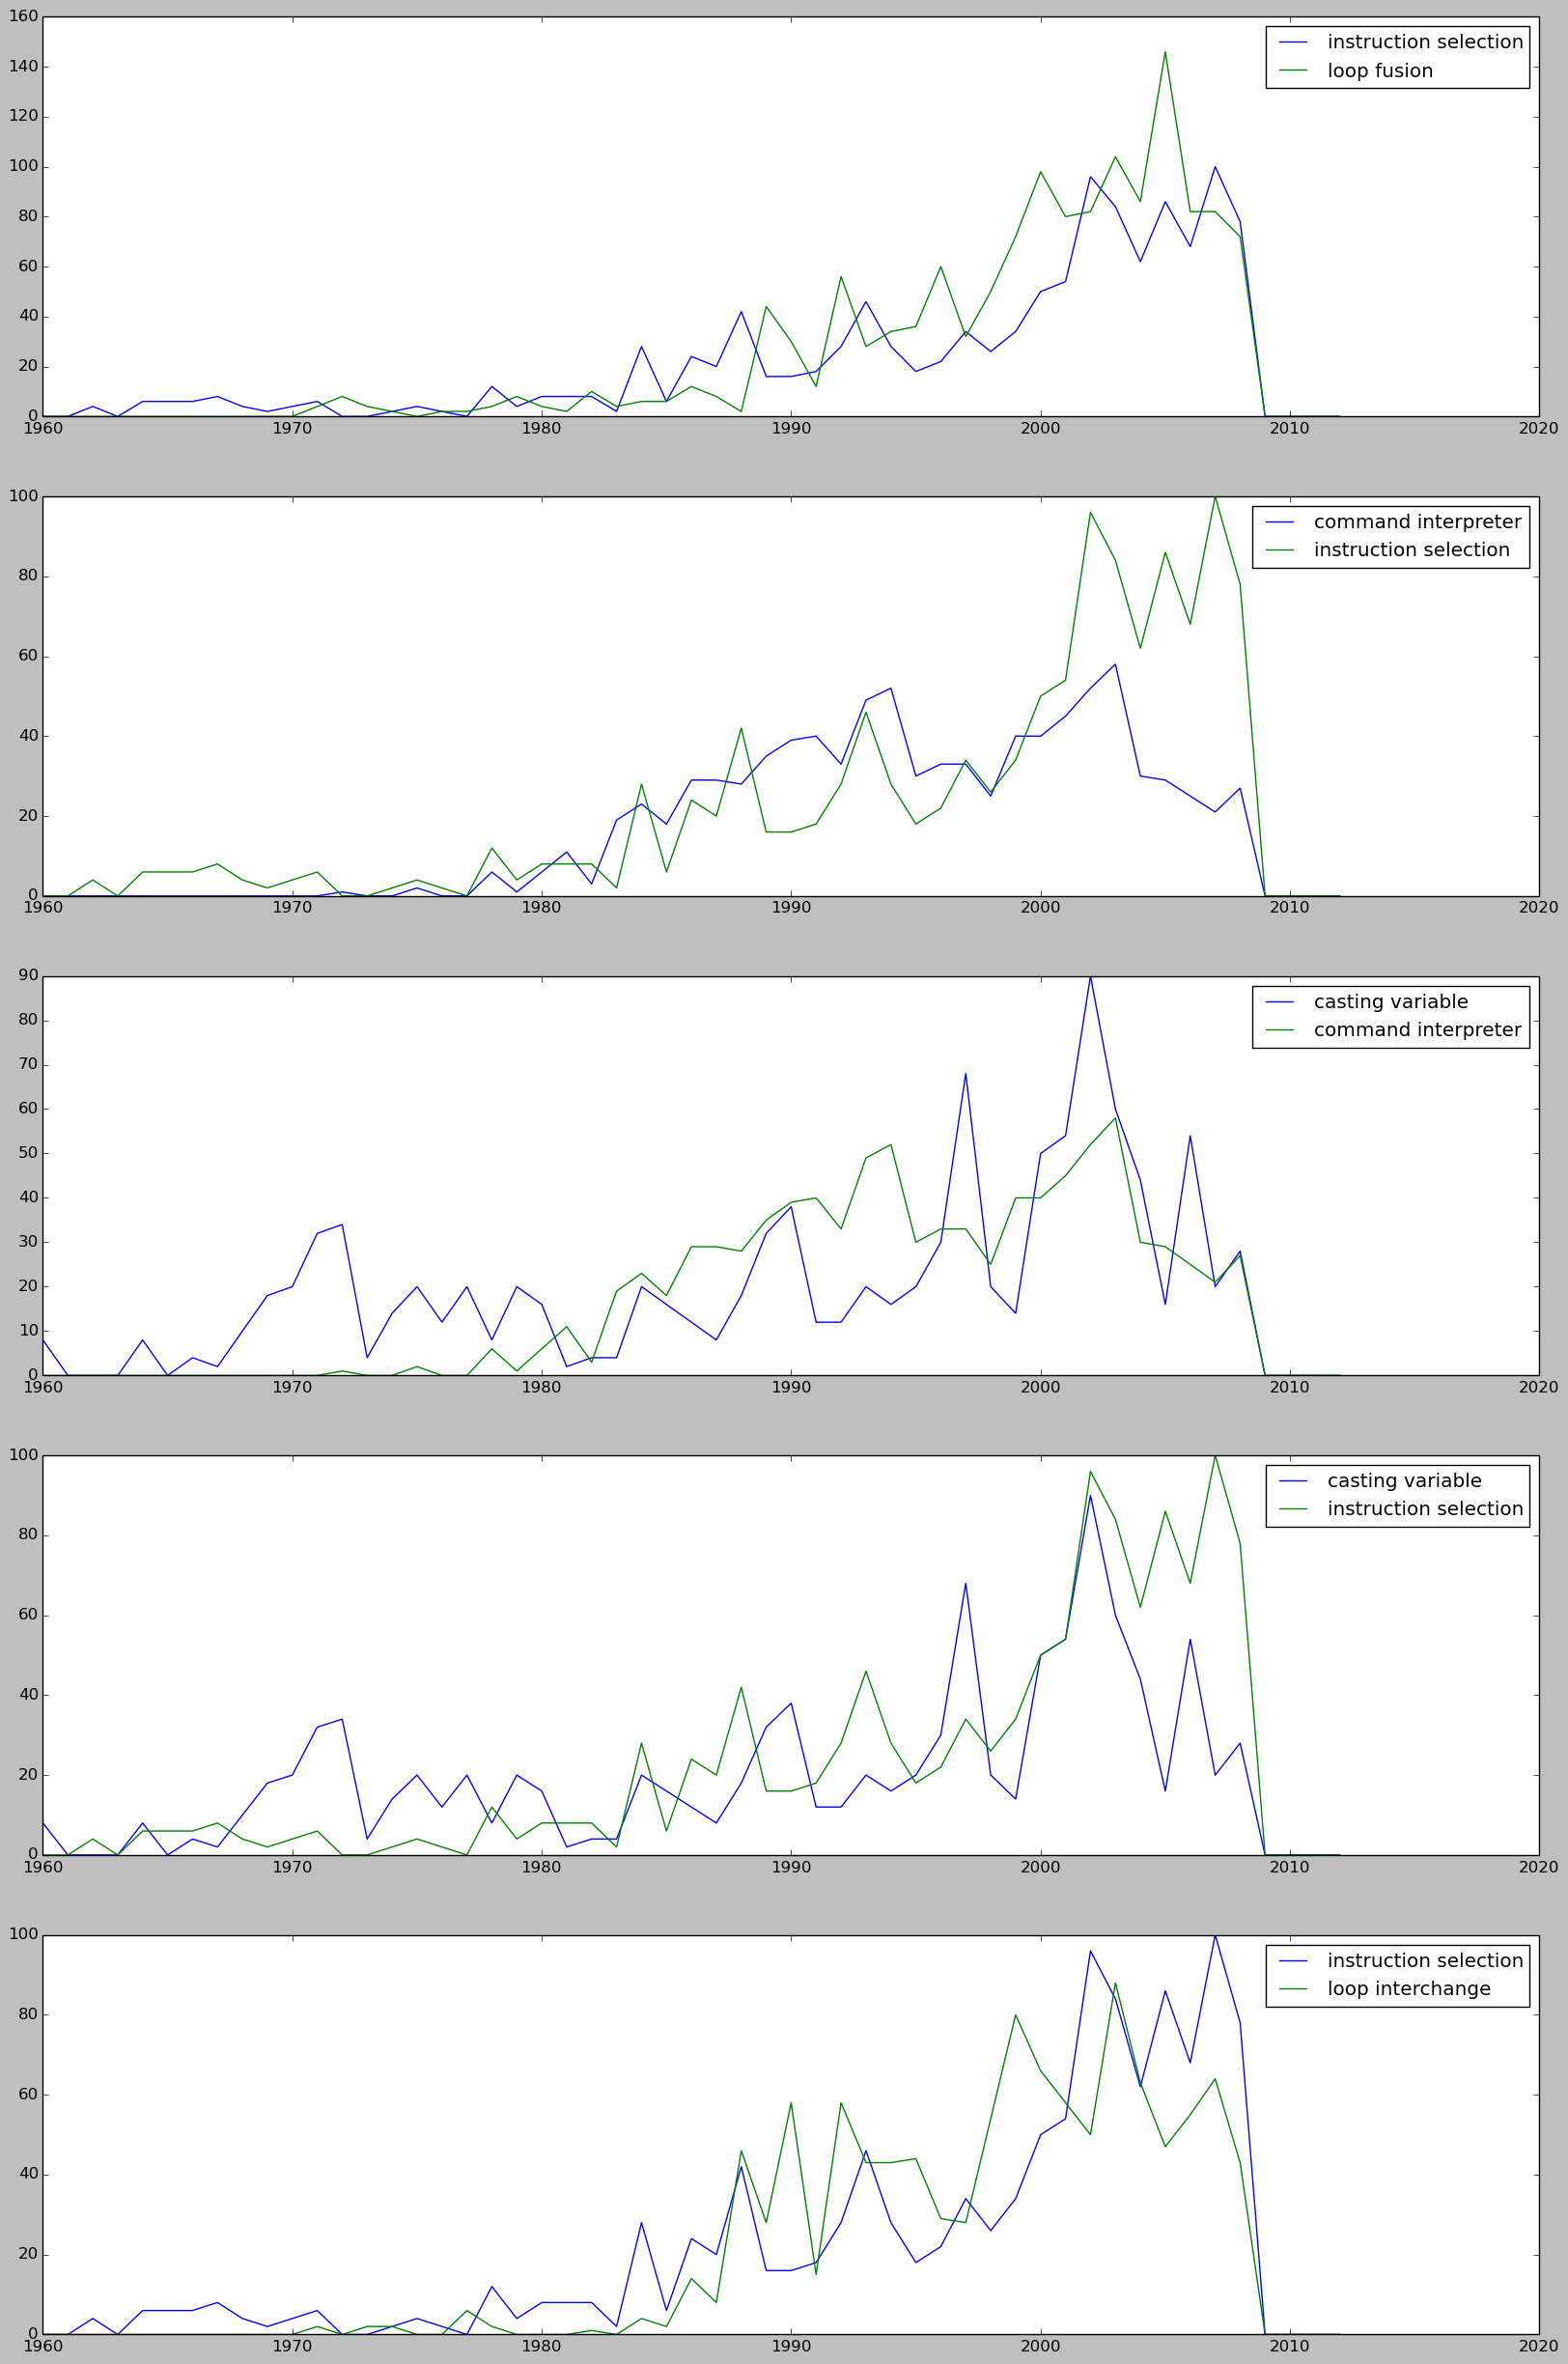

In [61]:
start = 1960
end = 2013
years = range(start, end)

num_plots = 5
fig = plt.figure(figsize=(20, num_plots*6))

for i in range(num_plots):
    # t1, t2 = l1_selected[i]  
    t1, t2 = l1_top[i]
    trend1 = get_vol_count(volTrendRDD, t1, start, end)
    trend2 = get_vol_count(volTrendRDD, t2, start, end)
    
    plt.subplot(num_plots, 1, i)
    line1, = plt.plot(years, trend1, label=t1)
    line2, = plt.plot(years, trend2, label=t2)
    plt.legend([line1, line2], [t1, t2])    

### L2-Distance

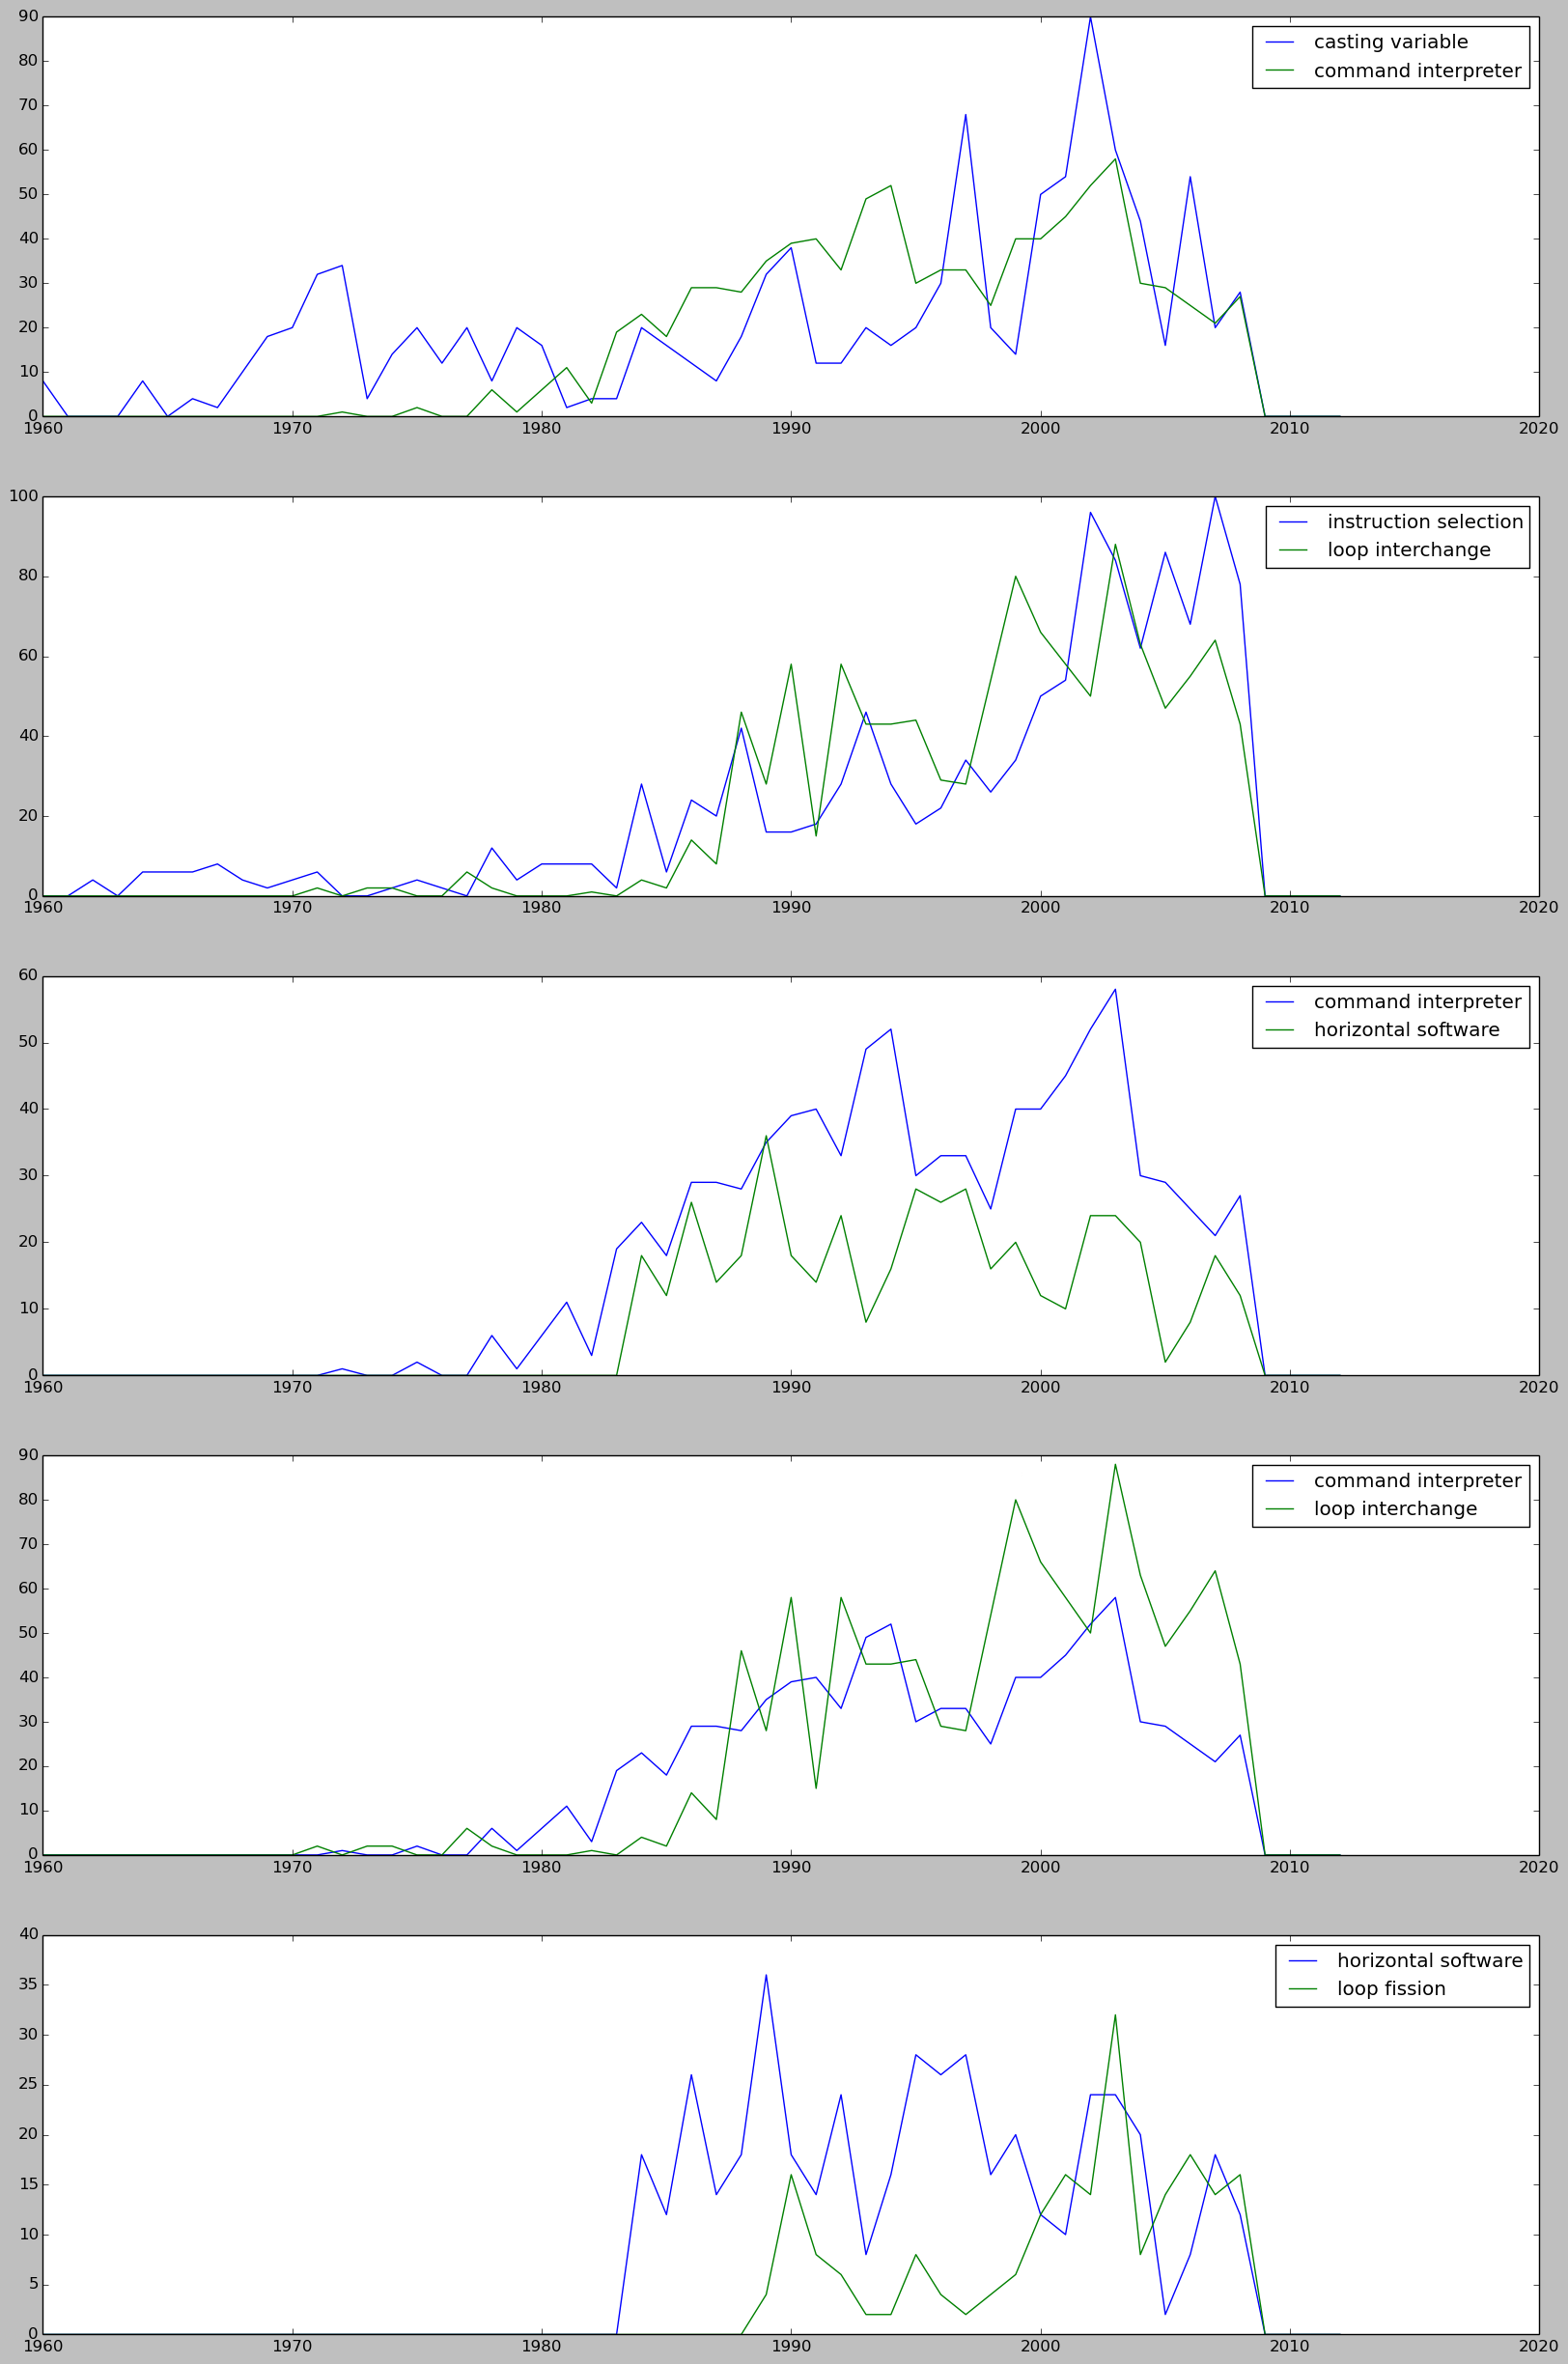

In [63]:
start = 1960
end = 2013
years = range(start, end)

num_plots = 5
fig = plt.figure(figsize=(20, num_plots*6))

for i in range(num_plots):
    # t1, t2 = l2_selected[i]  
    t1, t2 = l2_top[i]
    trend1 = get_vol_count(volTrendRDD, t1, start, end)
    trend2 = get_vol_count(volTrendRDD, t2, start, end)
    
    plt.subplot(num_plots, 1, i)
    line1, = plt.plot(years, trend1, label=t1)
    line2, = plt.plot(years, trend2, label=t2)
    plt.legend([line1, line2], [t1, t2]) 

### Cosine Similarity

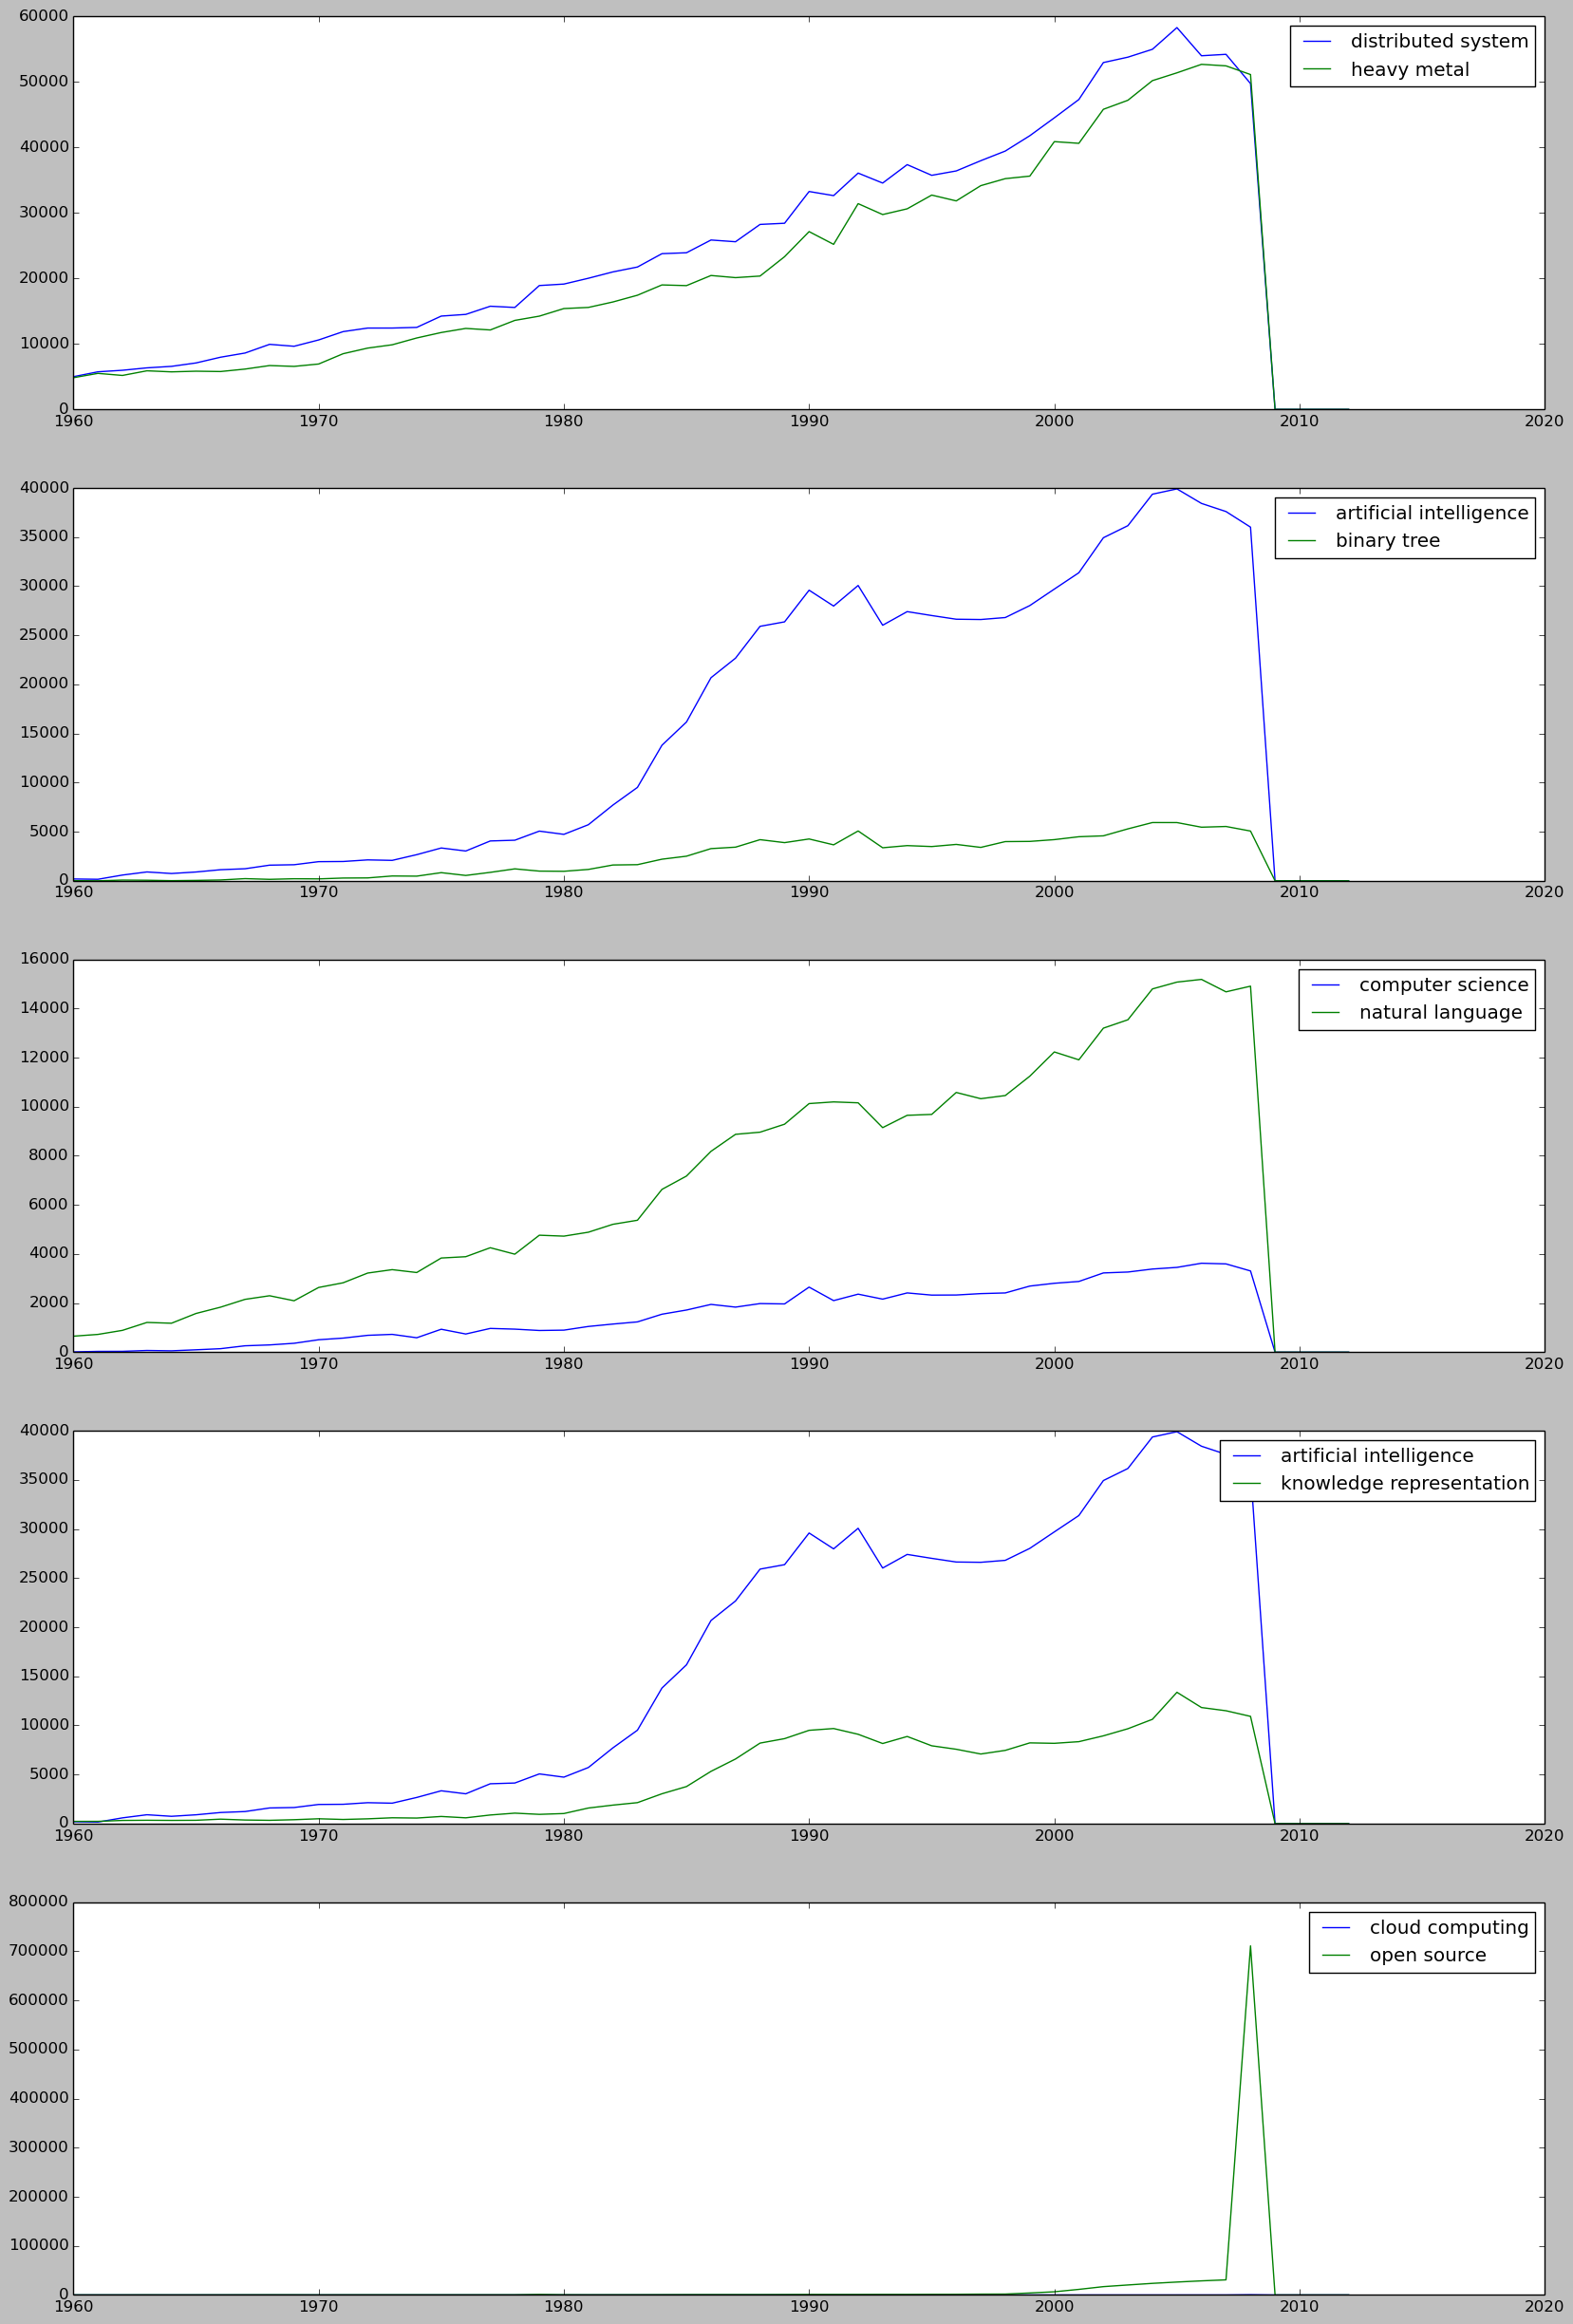

In [64]:
start = 1960
end = 2013
years = range(start, end)

num_plots = 5
fig = plt.figure(figsize=(20, num_plots*6))

for i in range(num_plots):
    # t1, t2 = cossim_selected[i]
    t1, t2 = cossim_top[i]
    trend1 = get_vol_count(volTrendRDD, t1, start, end)
    trend2 = get_vol_count(volTrendRDD, t2, start, end)
    
    plt.subplot(num_plots, 1, i)
    line1, = plt.plot(years, trend1, label=t1)
    line2, = plt.plot(years, trend2, label=t2)
    plt.legend([line1, line2], [t1, t2]) 